In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#read all words
words = open('names.txt').read().splitlines()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
#build the dataset
block_size = 3

def build_dataset(words):
    X,Y= [],[]
    for w in words:
        context = [0] * block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y

In [6]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [99]:
#MLP revisited
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the neural network

g = torch.Generator().manual_seed(42)
C = torch.randn(vocab_size, n_embd, generator=g)                                                            # character embeddings
W1 = torch.randn(n_embd*block_size, n_hidden, generator=g) * (5/3)*((1/n_embd*block_size)**(0.5))           # weights of the hidden layer
b1 = torch.randn(n_hidden, generator=g) * 0.1                                                               # bias of the hidden layer

W2 = torch.randn(n_hidden, vocab_size, generator=g)  * 0.01                 # weights of the output layer
b2 = torch.randn(vocab_size, generator=g)  * 0                              # bias of the output layer

bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C,W1,b1,W2,b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad_()


12297


In [100]:
#same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb = Xtr[ix]
    Yb = Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.size(0), -1)

    hpreact = embcat @ W1 + b1
    bnmeani = hpreact.mean(0,keepdim=True)
    bnstdi = hpreact.std(0,keepdim=True)
    hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi 

    h = torch.tanh(hpreact)
    logits = h@ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.item())

    #break



      0/ 200000:3.3108
  10000/ 200000:2.1317
  20000/ 200000:2.2811
  30000/ 200000:2.4523
  40000/ 200000:2.2241
  50000/ 200000:2.0298
  60000/ 200000:1.9054
  70000/ 200000:2.4249
  80000/ 200000:2.0215
  90000/ 200000:2.2272
 100000/ 200000:2.2330
 110000/ 200000:1.9336
 120000/ 200000:2.0017
 130000/ 200000:2.5312
 140000/ 200000:2.2729
 150000/ 200000:2.2060
 160000/ 200000:2.0807
 170000/ 200000:2.4864
 180000/ 200000:1.8564
 190000/ 200000:2.3242


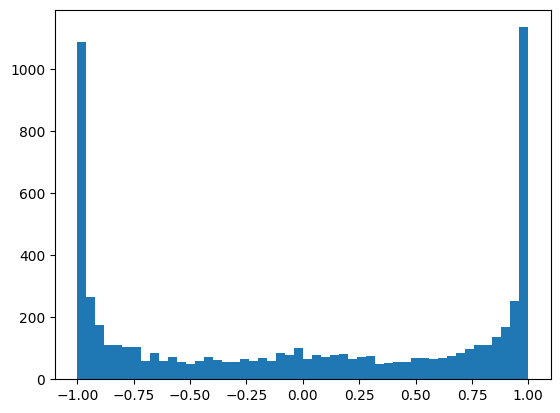

In [85]:
plt.hist(h.view(-1).tolist(),50);

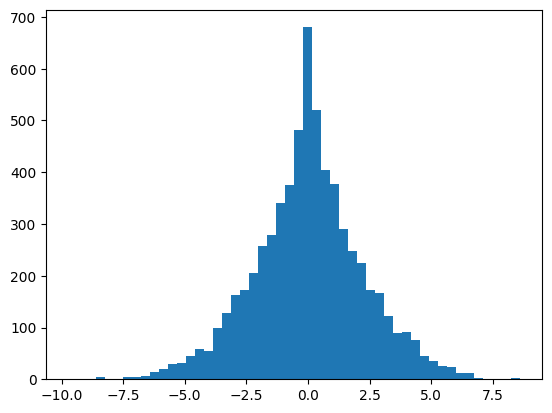

In [86]:
plt.hist(hpreact.view(-1).tolist(),50);

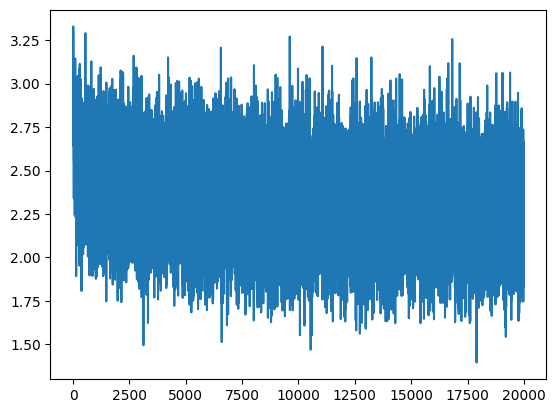

In [62]:
plt.plot(lossi)

In [101]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0,keepdim=True))/hpreact.std(0,keepdim=True) + bnbias
    h = torch.tanh(hpreact)
    logits = h@ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')
split_loss('test')


train 2.1099891662597656
dev 2.139702558517456
test 2.141040086746216


In [32]:
for _ in range(20):
    out = []
    context = [0] * block_size
    name = ''
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 + b1
        h = torch.tanh(hpreact)
        logits = h@ W2 + b2
        p = F.softmax(logits, dim=1)
        ix = torch.multinomial(p, 1, generator = g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
        name += itos[ix]
    print(name)

ceious
calle
ris
tue
jobmi
kingan
avimia
taison
molle
riyanna
endran
pakarsy
gramerson
arto
baret
allian
vechaibella
sohume
kado
lilanna


In [45]:
# 4 dimensional example
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()

logits, probs, loss

(tensor([0., 0., 0., 0.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

In [44]:
0.1167 + 0.0429 +0.5231 + 0.3173

1.0

In [ ]:
what do i want to do?
xtr, feed into a network, get Yte
network will have : c[xtr], linear layers, natchnorm layers, tnah layers,

after this, take f cross entropy; get loss Value
loss backward
laearning rate adjustment
plot tanh
plot pre activatiosn


In [33]:
n_embd = 10 # dimensionality of the character embedding vectors
vocab_size = 27
n_hidden = 200 # number of neurons in the hidden layer of the neural network

g = torch.Generator().manual_seed(42)

C =  torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden ), generator = g)
b1 = torch.randn(n_hidden, generator = g)
W2 = torch.randn((n_hidden, vocab_size), generator = g)
b2 = torch.randn(vocab_size, generator = g)

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.ones((1,n_hidden))
bnstd_running = torch.zeros((1,n_hidden))

parameters = [C,W1,W2,b1,b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12297


In [45]:
max_steps = 1000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat@ W1 + b1

    #batch norm layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim= True)
    hpreact = bngain* (hpreact - bnmeani)/bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact)
    logits = h@W2 + b2
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i<10000 else 0.01
    for p in parameters:
        p.data += -lr* p.grad

    if i%100 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/   1000:2.6787
    100/   1000:2.9213
    200/   1000:2.5459
    300/   1000:2.7669
    400/   1000:2.2965
    500/   1000:2.4036
    600/   1000:2.9022
    700/   1000:2.7798
    800/   1000:2.5173
    900/   1000:2.9519


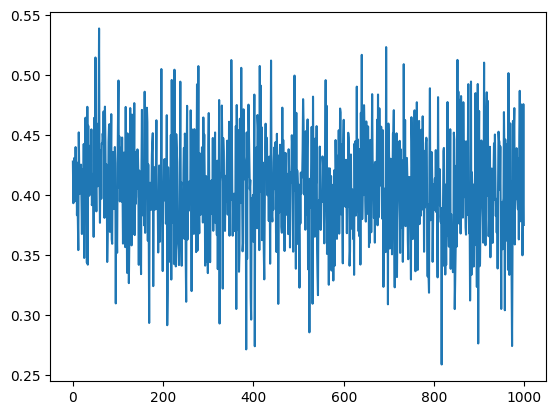

In [46]:
plt.plot(lossi)

In [ ]:
# training a deeper network and pytorchifying

n_embd = 10 # dimensionality of the character embedding vectors
vocab_size = 27
n_hidden = 200 # number of neurons in the hidden layer of the neural network

g = torch.Generator().manual_seed(42)

C =  torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden ), generator = g)
b1 = torch.randn(n_hidden, generator = g)
W2 = torch.randn((n_hidden, vocab_size), generator = g)
b2 = torch.randn(vocab_size, generator = g)

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.ones((1,n_hidden))
bnstd_running = torch.zeros((1,n_hidden))

parameters = [C,W1,W2,b1,b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

In [47]:
class Linear:

    def __init__ (self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator = g)/(fan_in**0.5)
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x@self.weight
        if self.bias is not None:
            self.out = self.out + self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    
    def __init__(self, dim, eps= 1e-05, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim = True)
            xvar = x.var(0, keepdim = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean)/torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum)*self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [48]:
n_embd = 10
n_hidden = 100
vocab_size = 27

C = torch.randn((vocab_size,n_embd), generator = g)
layers = [
    Linear(n_embd*block_size, n_hidden, bias = False),BatchNorm1d(n_hidden),Tanh(),
    Linear(       n_hidden, n_hidden, bias = False),BatchNorm1d(n_hidden),Tanh(),
    Linear(       n_hidden, n_hidden, bias = False),BatchNorm1d(n_hidden),Tanh(),
    Linear(       n_hidden, n_hidden, bias = False),BatchNorm1d(n_hidden),Tanh(),
    Linear(       n_hidden, n_hidden, bias = False),BatchNorm1d(n_hidden),Tanh(),
    Linear(       n_hidden, vocab_size, bias = False),BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer make less confident
    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1
    # all other layers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47024


In [109]:
#optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  #if i >= 1000:
    #break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 2.2087
  10000/ 200000: 2.1837
  20000/ 200000: 2.2485
  30000/ 200000: 2.2046
  40000/ 200000: 2.1821
  50000/ 200000: 1.9889
  60000/ 200000: 2.3002
  70000/ 200000: 1.9185
  80000/ 200000: 2.0519
  90000/ 200000: 2.1580
 100000/ 200000: 2.3463
 110000/ 200000: 1.8163
 120000/ 200000: 2.1552
 130000/ 200000: 1.9077
 140000/ 200000: 2.1793
 150000/ 200000: 2.4813
 160000/ 200000: 1.8172
 170000/ 200000: 2.0253
 180000/ 200000: 1.7915
 190000/ 200000: 1.8230


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 3.03%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.41%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.78%
layer 11 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.44%


Text(0.5, 1.0, 'activation distribution')

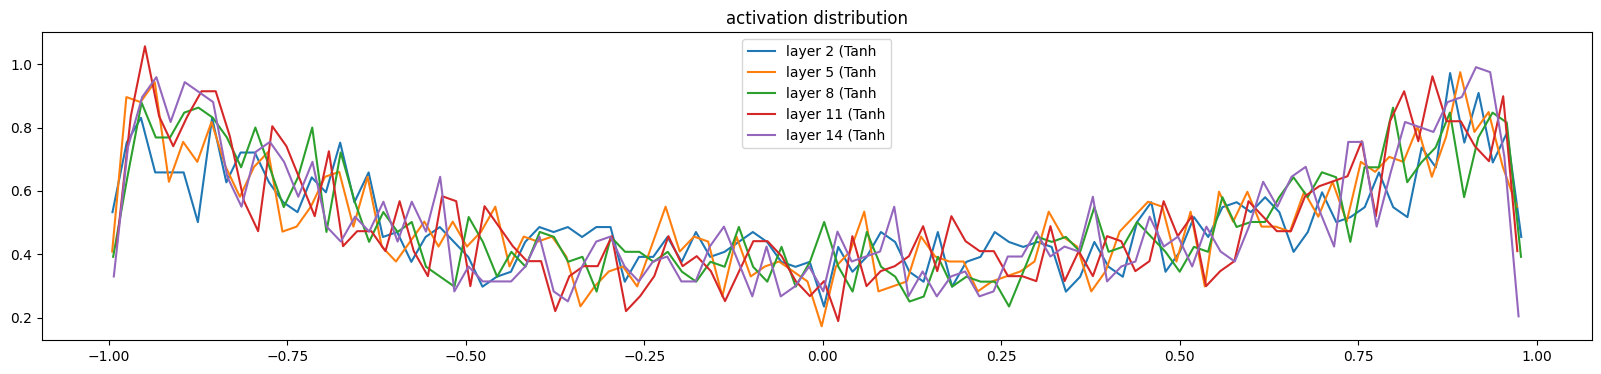

In [51]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 2.862973e-03
layer 5 (      Tanh): mean +0.000000, std 2.404272e-03
layer 8 (      Tanh): mean +0.000000, std 2.249121e-03
layer 11 (      Tanh): mean +0.000000, std 2.129992e-03
layer 14 (      Tanh): mean +0.000000, std 2.007218e-03


Text(0.5, 1.0, 'gradient distribution')

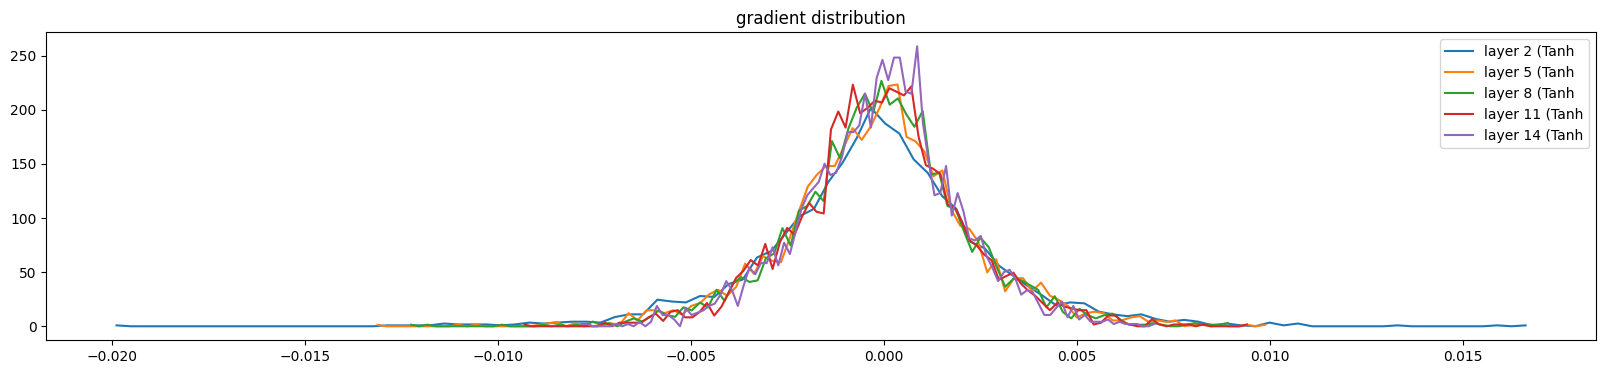

In [52]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 9.153003e-03 | grad:data ratio 8.869623e-03
weight  (30, 100) | mean +0.000082 | std 1.134495e-02 | grad:data ratio 6.229961e-02
weight (100, 100) | mean -0.000082 | std 7.126718e-03 | grad:data ratio 6.966536e-02
weight (100, 100) | mean +0.000001 | std 6.586359e-03 | grad:data ratio 6.500077e-02
weight (100, 100) | mean -0.000053 | std 6.188974e-03 | grad:data ratio 6.068750e-02
weight (100, 100) | mean +0.000118 | std 5.845658e-03 | grad:data ratio 5.744172e-02
weight  (100, 27) | mean -0.000080 | std 1.159117e-02 | grad:data ratio 1.123216e-01


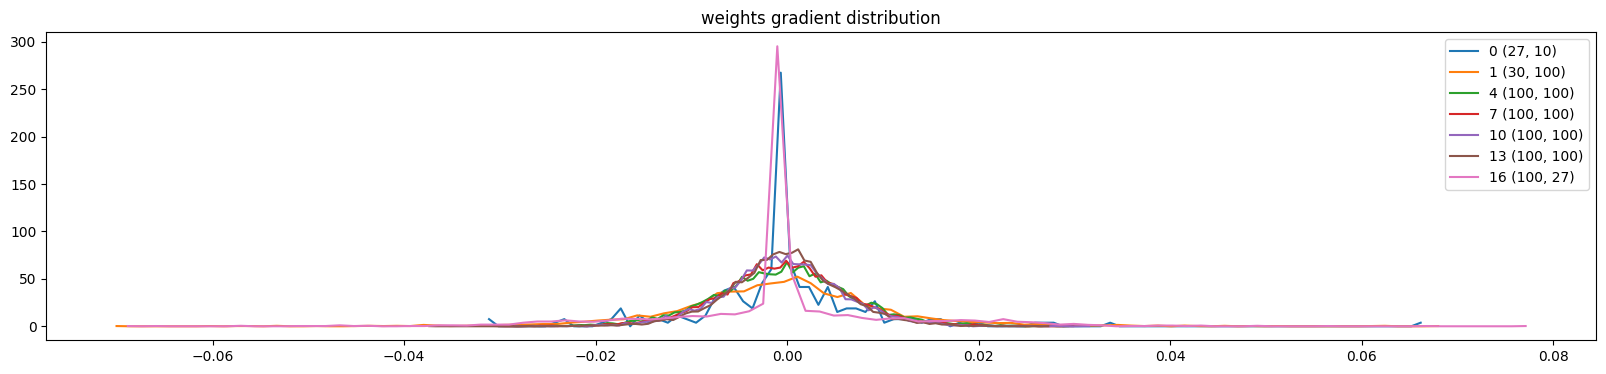

In [53]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

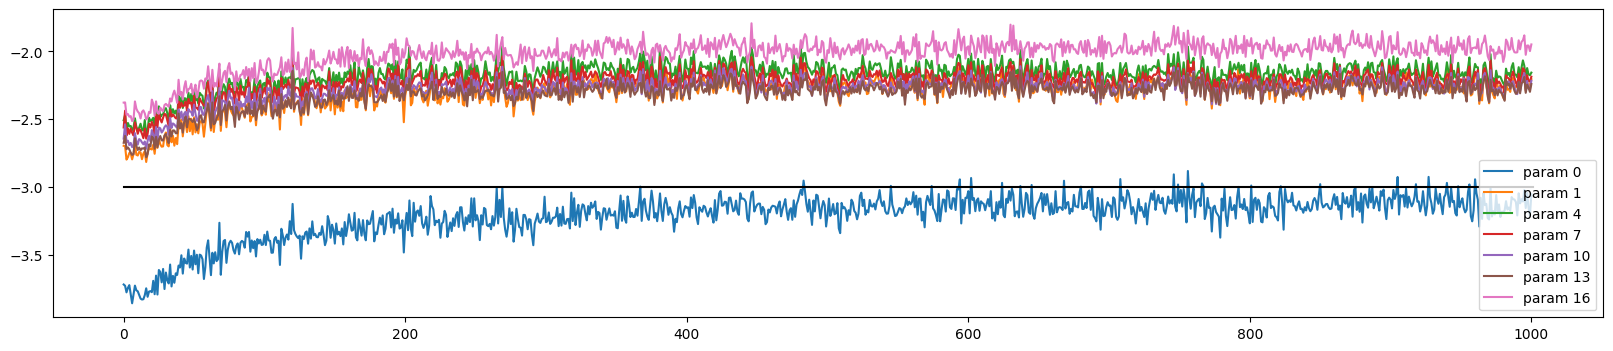

In [54]:

plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [55]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.3915834426879883
val 2.3853747844696045


In [56]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

mria.
mmyanzeeen.
ndheyalarethaslendra.
graderedielii.
shi.
jelleie.
sesnanaraelyn.
mhona.
mi.
shubergihimies.
kin.
reneliqxnterofiu.
mayvdir.
yadleyeh.
ylay.
mis.
kyan.
halina.
yansuhazelel.
juren.


In [77]:
t = torch.tensor([2.0,1.0,3.0,4.0,2.0])

In [78]:
hy, hx = torch.histogram(t)

In [79]:
hy.shape

torch.Size([100])

In [80]:
hx[:-1].shape

torch.Size([100])

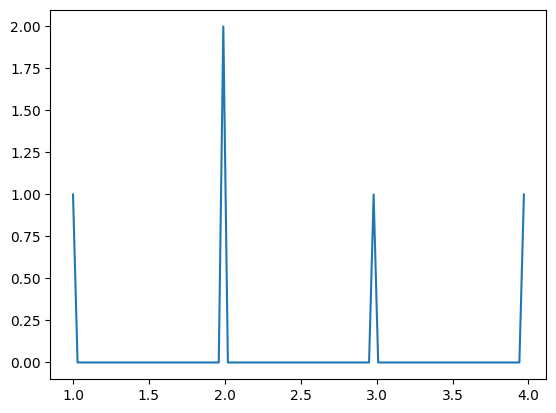

In [82]:
plt.plot(hx[:-1].detach(),hy.detach())

In [98]:
# Example usage
import torch
values = torch.randn(1000)  # Some random values
hist_y, hist_x = torch.histogram(values, bins=10)

In [106]:
hist_x

tensor([-3.1022, -2.4807, -1.8592, -1.2376, -0.6161,  0.0054,  0.6270,  1.2485,
         1.8700,  2.4915,  3.1131])

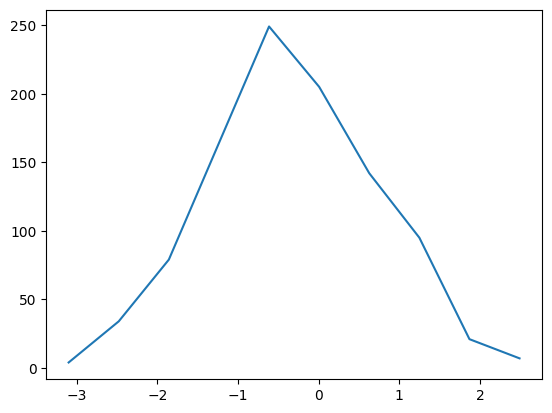

In [107]:
plt.plot(hist_x[:-1], hist_y)